In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from OCD import *

rng = np.random.seed(0)

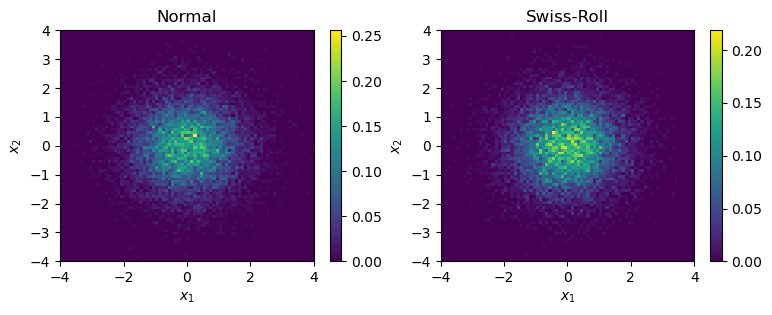

In [53]:
def swissroll(n=1000, noise=0.5):
    """
    Generate samples of a 2D Swiss roll distribution.

    Parameters:
    n (int)     : Number of points to generate (default: 1000)
    noise (float): Amount of Gaussian noise to add (default: 0.05)

    Returns:
    X (ndarray)  : An n x 2 matrix, where each row is a point (x, y) in 2D space
    """
    # Generate random values for the angle (theta) and height (z)
    theta = (3 * np.pi / 2) * (1 + 2 * np.random.rand(n, 1))  # Angle (theta) values for the spiral

    # Generate the (x, y) coordinates
    x = theta * np.cos(theta)
    y = theta * np.sin(theta)

    # Add Gaussian noise
    x += noise * np.random.randn(n, 1)
    y += noise * np.random.randn(n, 1)

    # Combine the coordinates into a matrix X
    X = np.hstack((x / 5., y / 5.))  # Dividing by 5 to match the scale

    return X

Np = 16000 # number of points/particles/samples
dim = 2

X = np.random.normal(0,1,(Np,dim))
#Y = swissroll(Np)
Y = np.random.normal(0,1,(Np,dim))

## store samples for future use
Y00 = Y.copy()
X00 = X.copy()

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

h1 = axes[0].hist2d(X[:,0],X[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
axes[0].set_title("Normal")
axes[0].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")
fig.colorbar(h1[-1], ax=axes[0])  # Add colorbar for the first plot

h2 = axes[1].hist2d(Y[:,0],Y[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
axes[1].set_title("Swiss-Roll")
axes[1].set_xlabel(r"$x_1$")
axes[1].set_ylabel(r"$x_2$")
fig.colorbar(h2[-1], ax=axes[1])  # Add colorbar for the first plot

epsilon =  0.0372759372031494
0.3428910498995781


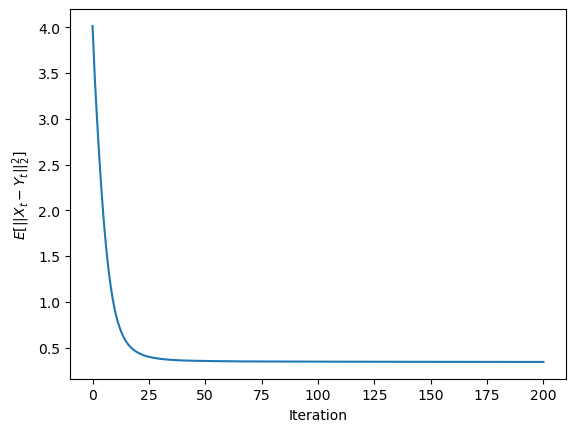

In [40]:
X0 = X00.copy()
Y0 = Y00.copy()

eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3,0], nepss = 400, perc=0.9998)
print("epsilon = ", eps0)

dt = 0.1
Nt = 200
tol = 1e-6

X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X0, Y0, dt=dt, Nt=200, sigma=eps0, tol=tol)

plt.figure()
plt.plot(dists)
plt.ylabel(r"$E[||X_t-Y_t||_2^2]$")
plt.xlabel("Iteration")   
print(dists[-1])

epsilon =  0.03189770215466321
0.30980889140955403


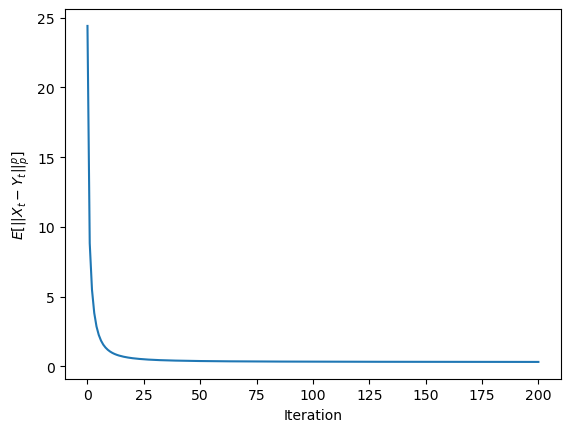

In [54]:
X0 = X00.copy()
Y0 = Y00.copy()
p=4

eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3,0], nepss = 400, perc=0.9998)
print("epsilon = ", eps0)

dt = 0.01
Nt = 200
tol = 1e-6

X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4_lp(X0, Y0, p=p, dt=dt, Nt=200, sigma=eps0, tol=tol)

plt.figure()
plt.plot(dists)
plt.ylabel(r"$E[||X_t-Y_t||_p^p]$")
plt.xlabel("Iteration")   
print(dists[-1])

In [15]:
## Load libraries
! pip3 install POT
import ot

def find_optimal_map_nd(X0, Y0, p=2, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0, p=p)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [55]:
x_emd = X0.copy()
y_emd = Y0.copy()
x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd, p=p)

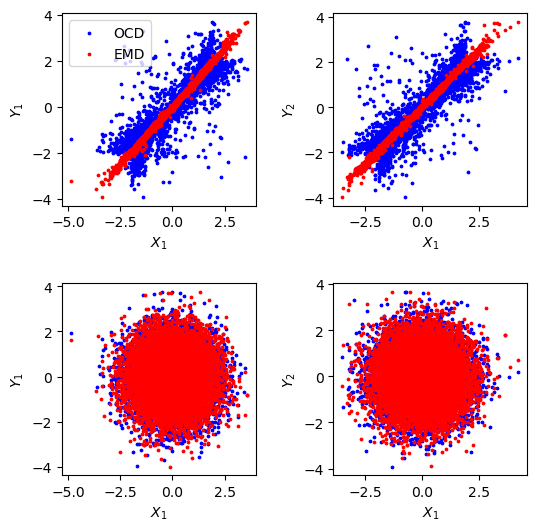

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0,0].scatter(X_ocd[:,0], Y_ocd[:,0], color="blue", s=3, label="OCD")
axes[0,0].scatter(x_emd[:,0], y_emd[:,0], color="red", s=3, label="EMD")
axes[0,0].set_xlabel(r"$X_1$")
axes[0,0].set_ylabel(r"$Y_1$")

axes[0,1].scatter(X_ocd[:,1], Y_ocd[:,1], color="blue", s=3)
axes[0,1].scatter(x_emd[:,1], y_emd[:,1], color="red", s=3)
axes[0,1].set_xlabel(r"$X_1$")
axes[0,1].set_ylabel(r"$Y_2$")

axes[1,0].scatter(X_ocd[:,0], Y_ocd[:,1], color="blue", s=3)
axes[1,0].scatter(x_emd[:,0], y_emd[:,1], color="red", s=3)
axes[1,0].set_xlabel(r"$X_1$")
axes[1,0].set_ylabel(r"$Y_1$")

axes[1,1].scatter(X_ocd[:,1], Y_ocd[:,0], color="blue", s=3)
axes[1,1].scatter(x_emd[:,1], y_emd[:,0], color="red", s=3)
axes[1,1].set_xlabel(r"$X_1$")
axes[1,1].set_ylabel(r"$Y_2$")

axes[0,0].legend()
fig.subplots_adjust(wspace=0.4, hspace=0.4)

0.00040729793576383045


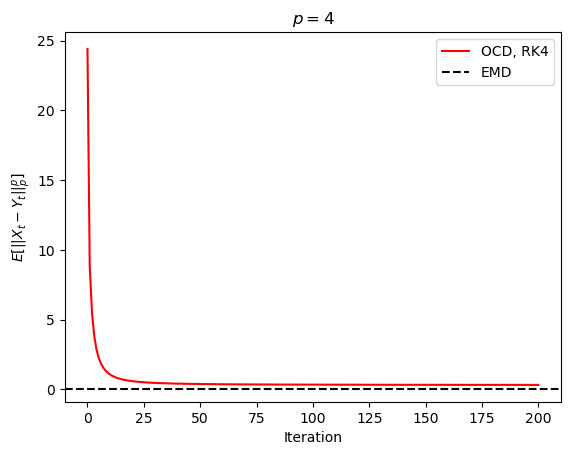

In [57]:
wemd = np.mean(np.sum((x_emd - y_emd) ** p, axis=1))
print(wemd)

plt.figure()
plt.title(r"$p=4$")
plt.plot(np.array(dists), label="OCD, RK4",color="red")
plt.ylabel(r"$E[||X_t-Y_t||_p^p]$")
plt.axhline(y=wemd, linestyle="--", label=f"EMD",color="black")
plt.xlabel("Iteration")

plt.legend()

# Save to file
plt.savefig("RK4_p4_2Normals_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [28]:
dists[-1]

1.4941689346171194

In [29]:
wemd

0.6923404076532361